In [1]:
import numpy as np
import torch
import torch.backends.cudnn as cudnn
from timm.models import create_model
import models_mamba
import utils
import os
from xai_utils import *
from class_mapper import CLS2IDX
import matplotlib.pyplot as plt

/home/ubuntu/workspace/envs/simba/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<h1>Load Model</h1>
Make sure to speiciy the model checkpoint path

In [ ]:
model_type = 'vim_small_patch16_224_bimambav2_final_pool_mean_abs_pos_embed_with_midclstok_div2'
model_path = './vim_s_midclstok_80p5acc.pth'
num_classes = 1000
model = create_model(
    model_type,
    pretrained=False,
    num_classes=num_classes,
    drop_rate=0,
    drop_path_rate=0,
    drop_block_rate=None,
    img_size=224
)
checkpoint = torch.load(model_path, map_location='cpu')
model.load_state_dict(checkpoint['model'])

In [5]:
model_type = 'vim_small_patch16_224_bimambav2_final_pool_mean_abs_pos_embed_with_midclstok_div2'
model_path = '/home/ubuntu/workspace/HiddenMambaAttn/checkpoint/vim_s_midclstok_80p5acc.pth'
num_classes = 1000
model = create_model(
    model_type,
    pretrained=False,
    num_classes=num_classes,
    drop_rate=0,
    drop_path_rate=0,
    drop_block_rate=None,
    img_size=224
)
checkpoint = torch.load(model_path, map_location='cpu')
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [8]:
model_type = 'vim_tiny_patch16_stride8_224_bimambav2_final_pool_mean_abs_pos_embed_with_midclstok_div2'
model_path = '/home/ubuntu/workspace/HiddenMambaAttn/checkpoint/vim_t_midclstok_ft_78p3acc.pth'
num_classes = 1000
model_1 = create_model(
    model_type,
    pretrained=False,
    num_classes=num_classes,
    drop_rate=0,
    drop_path_rate=0,
    drop_block_rate=None,
    img_size=224
)
checkpoint_1 = torch.load(model_path, map_location='cpu')
model_1.load_state_dict(checkpoint_1['model'])

<All keys matched successfully>

<h1>Auxiliary Functions</h1>

In [10]:
from PIL import Image
import torchvision.transforms as transforms

IMAGENET_DEFAULT_MEAN = [0.485, 0.456, 0.406]
IMAGENET_DEFAULT_STD = [0.229, 0.224, 0.225]

def transform_for_eval(image_path, input_size=224):
    transform_eval = transforms.Compose([
        transforms.Resize(int(input_size)),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
    ])
    img = Image.open(image_path).convert('RGB')
    transformed_img = transform_eval(img)
    return transformed_img

import cv2

invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam


def generate_visualization(original_image, transformer_attribution):
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).cuda().data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())
    image_transformer_attribution = original_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis =  np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis

def print_preds(logits):
    prob = torch.softmax(logits, dim=1)
    class_indices = logits.data.topk(5, dim=1)[1][0].tolist()
    max_str_len = 0
    class_names = []
    for cls_idx in class_indices:
        class_names.append(CLS2IDX[cls_idx])
        if len(CLS2IDX[cls_idx]) > max_str_len:
            max_str_len = len(CLS2IDX[cls_idx])

    print('Top 5 classes:')
    for cls_idx in class_indices:
        output_string = '\t{} : {}'.format(cls_idx, CLS2IDX[cls_idx])
        output_string += ' ' * (max_str_len - len(CLS2IDX[cls_idx])) + '\t\t'
        output_string += 'value = {:.3f}\t prob = {:.1f}%'.format(logits[0, cls_idx], 100 * prob[0, cls_idx])
        print(output_string)

In [11]:
model = model.cuda()

Top 5 classes:
	21 : kite                                                		value = 8.415	 prob = 75.0%
	24 : great grey owl, great gray owl, Strix nebulosa      		value = 5.133	 prob = 2.8%
	22 : bald eagle, American eagle, Haliaeetus leucocephalus		value = 4.807	 prob = 2.0%
	80 : black grouse                                        		value = 4.180	 prob = 1.1%
	82 : ruffed grouse, partridge, Bonasa umbellus           		value = 3.989	 prob = 0.9%


(-0.5, 223.5, 223.5, -0.5)

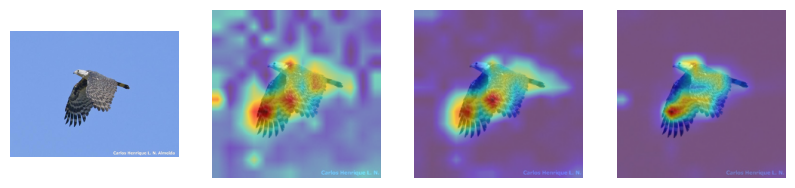

In [12]:
image  = transform_for_eval('./images/1.jpg').unsqueeze(0).cuda()
raw_image = Image.open('./images/1.jpg')
map_raw_atten, logits = generate_raw_attn(model, image)
map_mamba_attr, _ = generate_mamba_attr(model, image)
map_rollout, _ = generate_rollout(model, image)
image = image.squeeze()

raw_attn = generate_visualization(invTrans(image).detach().cpu(), map_raw_atten)
mamba_attr = generate_visualization(invTrans(image).detach().cpu(), map_mamba_attr)
rollout = generate_visualization(invTrans(image).detach().cpu(), map_rollout)
print_preds(logits)
fig, axs = plt.subplots(1, 4, figsize=(10,10))
axs[0].imshow(raw_image)
axs[0].axis('off')
axs[1].imshow(raw_attn)
axs[1].axis('off')
axs[2].imshow(rollout)
axs[2].axis('off')
axs[3].imshow(mamba_attr)
axs[3].axis('off')


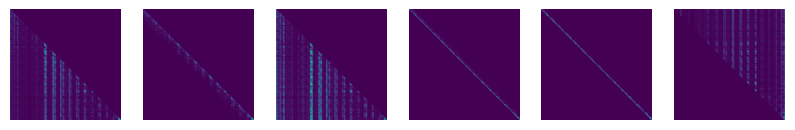

In [13]:
# Attention Matrices:
# Load an image and prepare it for model evaluation
image = transform_for_eval('./images/1.jpg').unsqueeze(0).cuda()

# Specify the layer and channel to analyze
selected_layer = 6
selected_channel = 30

# Enable computation of attention matrices in the model
model.layers[selected_layer].mixer.compute_attn_matrix = True
# Pass the image through the model
out = model(image)

# Extract and normalize attention matrices
attn_matrix_a = model.layers[selected_layer].mixer.attn_matrix_a.abs()
attn_matrix_b = model.layers[selected_layer].mixer.attn_matrix_b.abs()
normalize_attn_mat = lambda attn_mat : (attn_mat.abs() - torch.min(attn_mat.abs())) / (torch.max(attn_mat.abs()) - torch.min(attn_mat.abs()))
attn_matrix_a_normalize = normalize_attn_mat(attn_matrix_a)
attn_matrix_b_normalize = normalize_attn_mat(attn_matrix_b)

# Plot each attention matrix
fig, axs = plt.subplots(1, 6, figsize=(10,10))
for i in range(3):
    axs[i].imshow(attn_matrix_a.cpu().detach().numpy()[0, selected_channel+i, :, :])
    axs[i].axis('off')
    axs[i+3].imshow(attn_matrix_b.cpu().detach().numpy()[0, selected_channel+i, :, :])
    axs[i+3].axis('off')
    model.layers[selected_layer].mixer.compute_attn_matrix = False

Top 5 classes:
	26 : common newt, Triturus vulgaris                                 		value = 8.281	 prob = 64.1%
	25 : European fire salamander, Salamandra salamandra                		value = 6.831	 prob = 15.0%
	28 : spotted salamander, Ambystoma maculatum                        		value = 4.921	 prob = 2.2%
	32 : tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui		value = 4.587	 prob = 1.6%
	27 : eft                                                            		value = 3.485	 prob = 0.5%


(-0.5, 223.5, 223.5, -0.5)

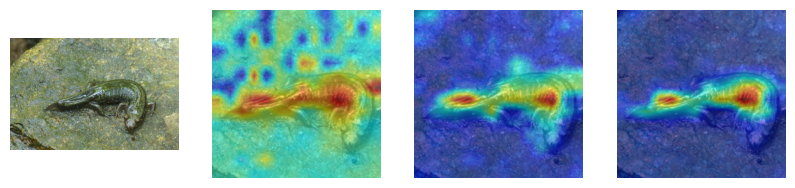

In [14]:
image  = transform_for_eval('./images/2.jpg').unsqueeze(0).cuda()
raw_image = Image.open('./images/2.jpg')
map_raw_atten, logits = generate_raw_attn(model, image)
map_mamba_attr, _ = generate_mamba_attr(model, image)
map_rollout, _ = generate_rollout(model, image)
image = image.squeeze()

raw_attn = generate_visualization(invTrans(image).detach().cpu(), map_raw_atten)
mamba_attr = generate_visualization(invTrans(image).detach().cpu(), map_mamba_attr)
rollout = generate_visualization(invTrans(image).detach().cpu(), map_rollout)
print_preds(logits)
fig, axs = plt.subplots(1, 4, figsize=(10,10))
axs[0].imshow(raw_image)
axs[0].axis('off')
axs[1].imshow(raw_attn)
axs[1].axis('off')
axs[2].imshow(rollout)
axs[2].axis('off')
axs[3].imshow(mamba_attr)
axs[3].axis('off')


Top 5 classes:
	31 : tree frog, tree-frog                                           		value = 8.803	 prob = 80.5%
	32 : tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui		value = 6.217	 prob = 6.1%
	317 : leafhopper                                                     		value = 3.659	 prob = 0.5%
	26 : common newt, Triturus vulgaris                                 		value = 3.163	 prob = 0.3%
	30 : bullfrog, Rana catesbeiana                                     		value = 3.119	 prob = 0.3%


(-0.5, 223.5, 223.5, -0.5)

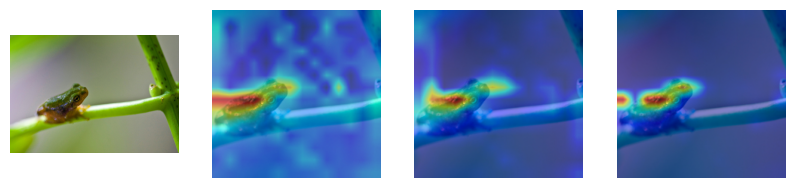

In [15]:
image  = transform_for_eval('./images/3.jpg').unsqueeze(0).cuda()
raw_image = Image.open('./images/3.jpg')
map_raw_atten, logits = generate_raw_attn(model, image)
map_mamba_attr, _ = generate_mamba_attr(model, image)
map_rollout, _ = generate_rollout(model, image)
image = image.squeeze()

raw_attn = generate_visualization(invTrans(image).detach().cpu(), map_raw_atten)
mamba_attr = generate_visualization(invTrans(image).detach().cpu(), map_mamba_attr)
rollout = generate_visualization(invTrans(image).detach().cpu(), map_rollout)
print_preds(logits)
fig, axs = plt.subplots(1, 4, figsize=(10,10))
axs[0].imshow(raw_image)
axs[0].axis('off')
axs[1].imshow(raw_attn)
axs[1].axis('off')
axs[2].imshow(rollout)
axs[2].axis('off')
axs[3].imshow(mamba_attr)
axs[3].axis('off')


In [ ]:
image  = transform_for_eval('./images/4.jpg').unsqueeze(0).cuda()
raw_image = Image.open('./images/4.jpg')
map_raw_atten, logits = generate_raw_attn(model, image)
map_mamba_attr, _ = generate_mamba_attr(model, image)
map_rollout, _ = generate_rollout(model, image)
image = image.squeeze()

raw_attn = generate_visualization(invTrans(image).detach().cpu(), map_raw_atten)
mamba_attr = generate_visualization(invTrans(image).detach().cpu(), map_mamba_attr)
rollout = generate_visualization(invTrans(image).detach().cpu(), map_rollout)
print_preds(logits)
fig, axs = plt.subplots(1, 4, figsize=(10,10))
axs[0].imshow(raw_image)
axs[0].axis('off')
axs[1].imshow(raw_attn)
axs[1].axis('off')
axs[2].imshow(rollout)
axs[2].axis('off')
axs[3].imshow(mamba_attr)
axs[3].axis('off')


Top 5 classes:
	77 : wolf spider, hunting spider		value = 7.343	 prob = 35.8%
	76 : tarantula                  		value = 6.469	 prob = 15.0%
	71 : scorpion                   		value = 5.317	 prob = 4.7%
	474 : cardigan                   		value = 5.265	 prob = 4.5%
	911 : wool, woolen, woollen      		value = 4.921	 prob = 3.2%


(-0.5, 223.5, 223.5, -0.5)

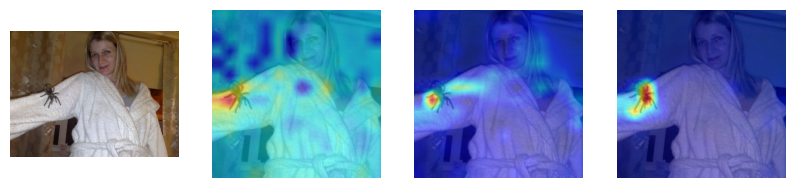

In [16]:
image  = transform_for_eval('./images/5.jpg').unsqueeze(0).cuda()
raw_image = Image.open('./images/5.jpg')
map_raw_atten, logits = generate_raw_attn(model, image)
map_mamba_attr, _ = generate_mamba_attr(model, image)
map_rollout, _ = generate_rollout(model, image)
image = image.squeeze()

raw_attn = generate_visualization(invTrans(image).detach().cpu(), map_raw_atten)
mamba_attr = generate_visualization(invTrans(image).detach().cpu(), map_mamba_attr)
rollout = generate_visualization(invTrans(image).detach().cpu(), map_rollout)
print_preds(logits)
fig, axs = plt.subplots(1, 4, figsize=(10,10))
axs[0].imshow(raw_image)
axs[0].axis('off')
axs[1].imshow(raw_attn)
axs[1].axis('off')
axs[2].imshow(rollout)
axs[2].axis('off')
axs[3].imshow(mamba_attr)
axs[3].axis('off')
